## Setup

In [1]:
#%matplotlib widget;
#%matplotlib inline;
#pygui(true);

In [2]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

  Activating project at `C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT`


6

2023-05-04T23:16:49.522

In [3]:
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Bases.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")
@everywhere include(dir * "/functions/SingleVertexApproxns.jl")

@everywhere include(dir * "/functions/simulationFunctions/GroundStates.jl")

## GLOBAL INPUTS

### Energy Scales

In [4]:
# Hamiltonian constants
@everywhere global const λ::Float64 = 0
@everywhere global const ξ::Float64 = 1

# which dynamics to use (only affects microcanonical functions)
@everywhere global const twoFlip::Bool = true

# demon quantisation
@assert (λ==1 && ξ==0) || (λ==0 && ξ==1) # otherwise demons will break b/c not quantised
@everywhere global const δE::Int = (λ==0) ? 8*ξ : 4*λ

### Lattice

In [5]:
# chosen basis
Basis = CubicBasis(2) # HexBasis() #

# function to generate groundstate
@everywhere GroundState!(vertices, edges) = GroundState!(vertices, edges, Basis == DiamondBasis())

## Testing Data Structure

In [6]:
vertices, edges = LatticeGrid([2, 2, 2], [false, false, false], DiamondBasis())

GroundState!(vertices, edges, true)

Lvertices, Ledges = LineGraph(vertices, edges);

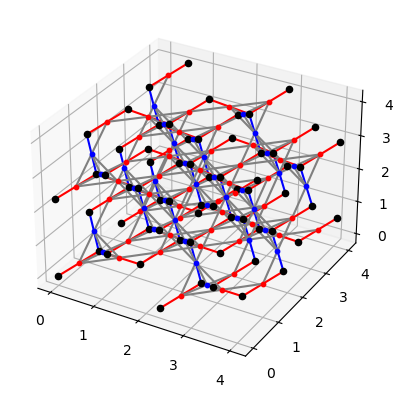

In [7]:
f = figure()
for e in edges
    r1 = vertices[e.∂[1]].x
    r2 = vertices[e.∂[2]].x

    plot3D([r1[1]; r2[1]], [r1[2]; r2[2]], [r1[3]; r2[3]], color=(e.σ ? :red : :blue), zorder=1) 
end

for v in vertices
   scatter3D(v.x[1], v.x[2], v.x[3], color=:black, zorder=2)
end

for e in Ledges
    r1 = Lvertices[e.∂[1]].x
    r2 = Lvertices[e.∂[2]].x

    plot3D([r1[1]; r2[1]], [r1[2]; r2[2]], [r1[3]; r2[3]], color=:grey, zorder=1) 
end

for v in Lvertices
   scatter3D(v.x[1], v.x[2], v.x[3], color=(v.σ ? :red : :blue), s=10, zorder=2) # color=(A(edges,v)<0 ? :yellow : :black)  
end

#axis("off"); # axis("off") # 

## Thermal Conductivity

## Thermal Bath Method


In [8]:
@everywhere include(dir * "/functions/simulationFunctions/DemonHeatBath.jl")

In [9]:
L = [40, 30]
PBC = [false, true]

𝒽 = [0.0]

num_histories = 15
therm_runtime = 1000
runtime = 1000
t_therm = 500
t_autocorr = 1
N_blocks = -1

W = 5
Tc = 0.1
Th = 10.0

T, κ, C, TStd, κStd, CStd = BathSimulation(L, PBC, Basis, W, Tc, Th, num_histories, therm_runtime, runtime, t_therm, t_autocorr, N_blocks, 𝒽);

idx = W+1:size(T, 2)-W+2;

In [10]:
# FUDGE FACTOR - WHYYY MISSING FACTOR 1/2????
κ[1,:,:] ./= 2;
κ[2,:,:] ./= 2;

In [11]:
z = Coordination(Basis)
colors = jetmap(length(𝒽))

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

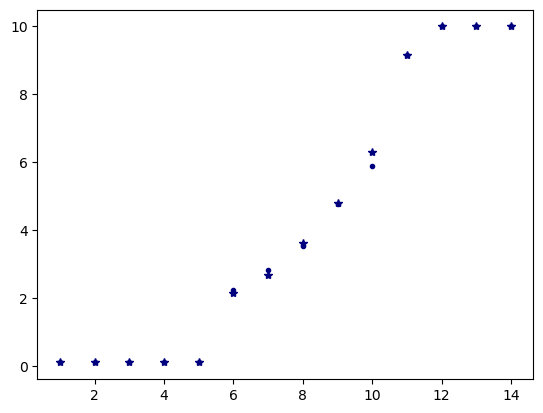

In [12]:
figure()
for i in eachindex(𝒽)
    plotWithError(T[1,:,i], 1:size(T, 2), colors[i], ".", TStd[1,:,i])
    plotWithError(T[2,:,i], 1:size(T, 2), colors[i], "*", TStd[2,:,i])
    #plotWithError(T[1,idx,i], 1:length(idx), colors[i], ".", TStd[1,idx,i])
    #plotWithError(T[2,idx,i], 1:length(idx), colors[i], "*", TStd[2,idx,i])
end
savefig("figs/Demon_Bath_Temperatures.png")

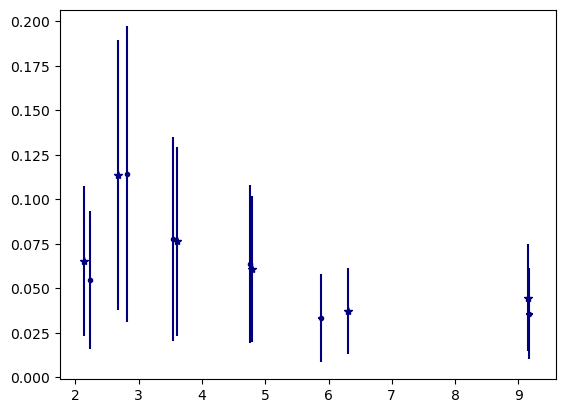

In [13]:
figure()
for i in eachindex(𝒽)
    plotWithError(κ[1,idx,i], T[1,idx,i], colors[i], ".", κStd[1,idx,i], TStd[1,idx,i])
    plotWithError(κ[2,idx,i], T[2,idx,i], colors[i], "*", κStd[2,idx,i], TStd[2,idx,i])
end
#ylim([0, 0.3])
savefig("figs/Demon_Bath_Conductivity.png")

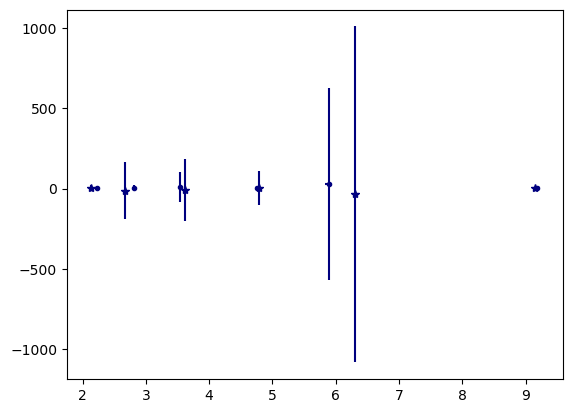

In [14]:
figure()
for i in eachindex(𝒽)
    plotWithError(C[1,idx,i], T[1,idx,i], colors[i], ".", CStd[1,idx,i], TStd[1,idx,i])
    plotWithError(C[2,idx,i], T[2,idx,i], colors[i], "*", CStd[2,idx,i], TStd[2,idx,i])
end
savefig("figs/Demon_Bath_Capacity.png")

In [15]:
T = Nothing
κ = Nothing

Nothing

In [16]:
t1 = now()
print("\n", canonicalize(t1 - t0))


17 seconds, 866 milliseconds

## Green-Kubo Method

### Demon Dynamics

In [17]:
@everywhere include(dir * "/functions/simulationFunctions/DemonKubo.jl")

In [18]:
#global testing = []

# PARAMETERS
L = [40, 30]
PBC = [true, true]

# find minimal representable temperature (just done for 𝒽=0 for now - MAYBE MODIFY TO PICK MAX OVER DIFF FIELDS??
#Nmin = (T,h) -> (λ == 0 ? 2/(4*exp(-4/T)/3+h*exp(-2*h/T)) : 2/(exp(-2/T)+2*h*exp(-2*h/T))) # minimal lattice size on which T=Tmin is possible - see https://www.desmos.com/calculator/ll1ljvjmcg for details
Tmin = 0.1 # find_zero((T) -> prod(L)-Nmin(T,0), 0.3)
Tmax = 10.0
NumT = 30
T = collect(range(Tmin, Tmax, length=NumT)) # the +0.1 is a fudge factor to fix our approximations earlier... (exact value doesn't matter b/c just adds ~a single demon)

𝒽 = [0.0] #range(0, 1, length=5)

num_histories = 15
runtime = 10000
t_cutoff = 1000
t_therm = 5000
t_autocorr = 100
N_blocks = -1

# EVALUATION
Tobs, κ, C, Diff, TobsStd, κStd, CStd, DiffStd = DKuboSimulation(L, PBC, Basis, num_histories, runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽);

In [19]:
now()

2023-05-04T23:17:49.796

In [20]:
z = Coordination(Basis)
colors = jetmap(length(𝒽))

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

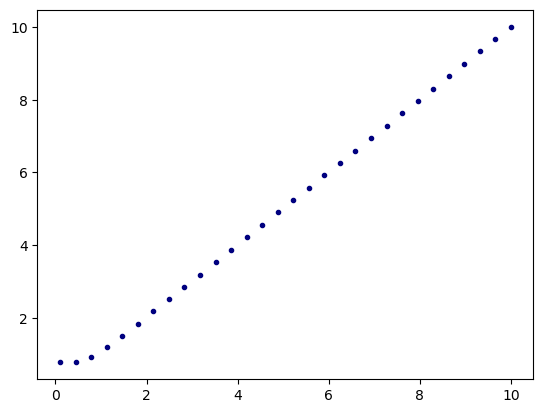

In [21]:
figure()
#plot(T, T, color=:black)
for i in eachindex(𝒽)
    plotWithError(Tobs[:,i], T, colors[i], ".", TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Temperature.png")
# Just to check that out temperature estimates aren't too far off

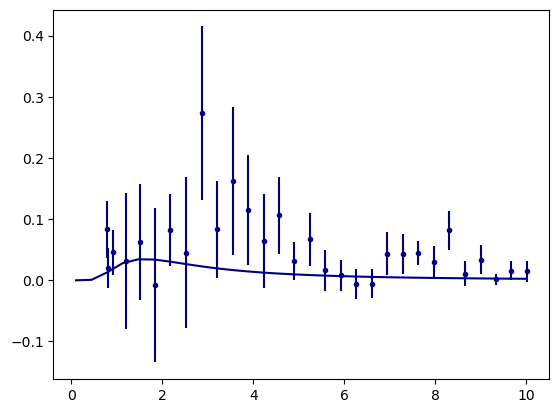

In [22]:
if twoFlip
    Kfun = (T, h) -> (2 .* ExcitationDensity(T, h, z) ./ T.^2) .* (1 .- ExcitationDensity(T, h, z)) .* (1 .- Magnetisation(T, h, z)) ./ 2 # additional magnetisation factor for +-+- bond percolation
else
    Kfun = (T, h) -> (2 .* ExcitationDensity(T, h, z) ./ T.^2) .* (1 .- ExcitationDensity(T, h, z))
end

figure()
for i in eachindex(𝒽)
    plot(T, Kfun(T, 𝒽[i]), color=colors[i])
    plotWithError(κ[:,i], Tobs[:,i], colors[i], ".", κStd[:,i], TobsStd[:,i])
end
#ylim([0, 0.3])
savefig("figs/Demon_Kubo_Conductivity.png")

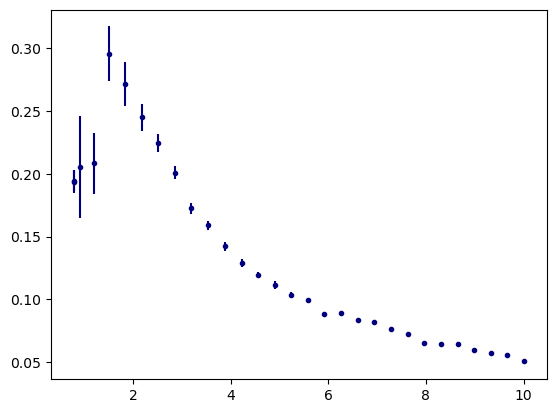

In [23]:
figure()
#plot(T, 0.5 ./ T.^2 ./ cosh.(1 ./T).^2, color=:black)
for i in eachindex(𝒽)
    plotWithError(C[:,i], Tobs[:,i], colors[i], ".", CStd[:,i], TobsStd[:,i])
end
#ylim([0, 0.3])
savefig("figs/Demon_Kubo_Capacity.png")

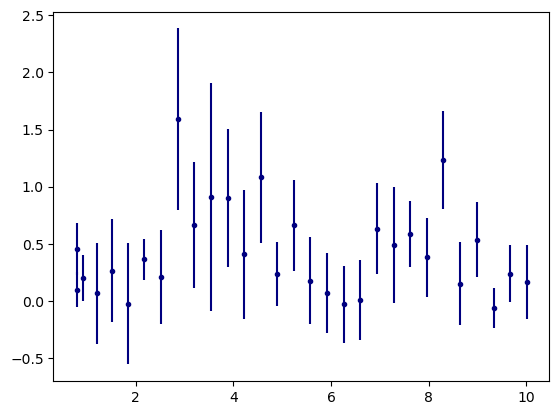

In [24]:
figure()
#plot(T, ones(size(T)), color=:black)
for i in eachindex(𝒽)
    plotWithError(Diff[:,i], Tobs[:,i], colors[i], ".", DiffStd[:,i], TobsStd[:,i])
end
#ylim([0, 2.0])
savefig("figs/Demon_Kubo_Diff.png")

In [25]:
κ = Nothing
C_σ = Nothing
κStd = Nothing 
C_σStd = Nothing

Nothing

In [26]:
t2 = now()
print(canonicalize(t2 - t1))

43 seconds, 320 milliseconds

### Microcanonical Dynamics

In [27]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [53]:
# PARAMETERS
L = [40, 30]
PBC = [true, true]

Tmin = 0.01
Tmax = 10.0
NumT = 30

#Tmax *= (λ == 0 ? 1.0 : 0.5)
T = collect(range(Tmin, Tmax, length=NumT))

𝒽 = [0.0] #range(0, 1, length=5)

num_histories = 15
therm_runtime = 10000
runtime = 10000
t_therm = 5000
t_autocorr = 100
N_blocks = -1
t_cutoff = 100

allComponents = false

# EVALUATION
κ, C, Diff, M, ℙ, κStd, CStd, DiffStd, MStd, ℙStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽, allComponents);

In [54]:
now()

2023-05-04T23:37:16.601

In [55]:
z = Coordination(Basis)
colors = jetmap(length(𝒽));

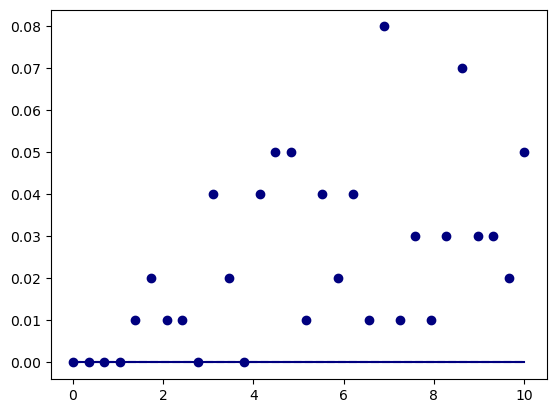

In [56]:
figure()
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M)
function Mfun(T, h)
    m = zeros(length(T))
    
    if h==0
        return m
    end
    
    for i in eachindex(T)
        m[i] = find_zero((M) -> Tfun(M, h) - T[i], (0, 1))
    end
    return m
end

Mfun0 = (T, h) -> tanh.(h ./ T)

for n in eachindex(𝒽)
    plot(T, Magnetisation(T, 𝒽[n], z), color=colors[n])
    plot(T, tanh.(𝒽[n] ./ T), "--", color=colors[n])
    scatter(T, M[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Magnetisation.png")

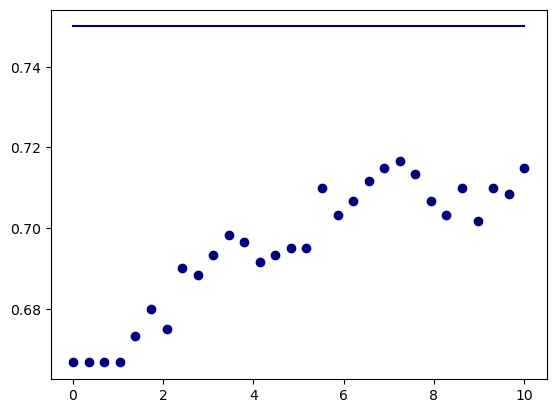

In [57]:
figure()
#ℙfunMF = (T, h) -> 1 .- (1 .- Mfun0(T, h) .^2) ./ 3
ℙfunLim = (T, h) -> 1 .- (1 .- Magnetisation(T, h, z) .^2) ./ 4

for n in eachindex(𝒽)
    plot(T, ℙfunLim(T, 𝒽[n]), color=colors[n])
    scatter(T, ℙ[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Percolation.png")

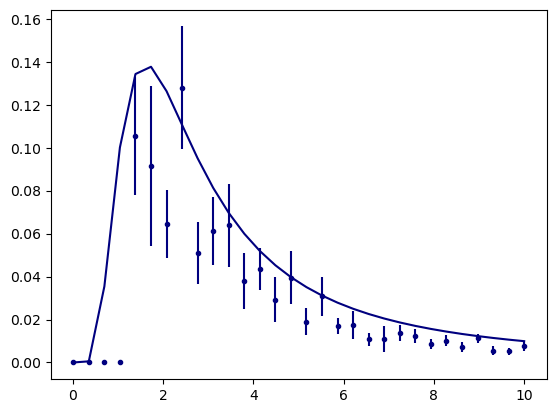

In [58]:
if twoFlip
    Kfun = (T, h) -> 0.5 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- ExcitationDensity(T, h, z)) .* (1 .- Magnetisation(T, h, z)) ./ 2 # additional magnetisation factor for +-+- bond percolation
else
    Kfun = (T, h) -> 0.5 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- ExcitationDensity(T, h, z))
end

dim = allComponents ? length(L) : 1


for i in 1:dim
    for j in 1:dim
        figure()
        for n in eachindex(𝒽)
            plot(T, Kfun(T, 𝒽[n]), color=colors[n])

            plotWithError(κ[i,j,:,n], T, colors[n], ".", κStd[i,j,:,n])
        end

        savefig("figs/Micro_Kubo_Conductivity_" * string(i) * string(j) * ".png")
    end
end

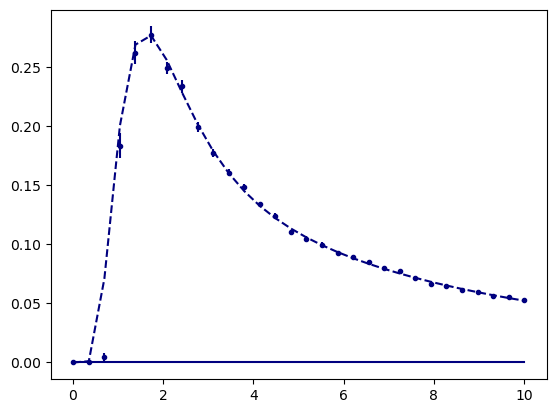

In [59]:
figure()
Cfun = (T, h) -> (sech.(1 ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ 2 .* λ ./ T.^2
for n in eachindex(𝒽)
    plot(T, Cfun(T, 𝒽[n]), color=colors[n])
    plot(T, HeatCapacity(T, 𝒽[n], z), "--", color=colors[n])
    plotWithError(C[:,n], T, colors[n], ".", CStd[:,n])
end
savefig("figs/Micro_Kubo_Capacity.png")

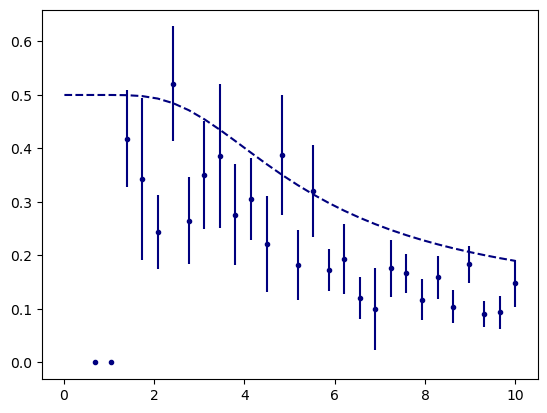

In [60]:
Dfun = (T, h) -> Kfun(T, h) ./ HeatCapacity(T, h, z)
Dfun0  = (T, h) -> Kfun(T, h) ./ Cfun(T, h)

figure()
for i in 1:dim
    for j in 1:dim
        figure()
        for n in eachindex(𝒽)
            plot(T, Dfun(T, 𝒽[n]), color=colors[n], "--")
            plot(T, Dfun0(T, 𝒽[n]), color=colors[n])

            plotWithError(Diff[i,j,:,n], T, colors[n], ".", DiffStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Diff_" * string(i) * string(j) * ".png")
    end
end

In [36]:
κ = Nothing
C_σ = Nothing
κStd = Nothing 
C_σStd = Nothing

Nothing

In [37]:
t3 = now()
print("\n", canonicalize(t3 - t2))


2 minutes, 18 seconds, 817 milliseconds

### Diffusive Motion

In [38]:
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")

In [39]:
L = [40, 30]
PBC = [true, true]

therm_runtime = 1000
runtime = 2000
tau = 2:floor(Int64, 0.75*runtime)
num_histories = 10
𝒽 = [0.0] #range(0, 2, length=5)

T = []; #range(0.01, 10.0, length=15);
ℓ = [1, 1]; # floor.(Int64, range(1, prod(L)/4, length=20));


x, δ, Mag, Perc, p, Nv = DiffSim(L, PBC, Basis, therm_runtime, runtime, ℓ, T, 𝒽);
D, α, C, γ, MSD, StepCorr = DiffAnalysis(x, δ, p, runtime, ℓ, T, 𝒽);

In [40]:
#figure()
#for prtcl in 1:size(x[1][1][1], 2)
#    plot(x[1][1][1][1,prtcl,:], x[1][1][1][2,prtcl,:])
#end

In [41]:
z = Coordination(Basis)
colors = jetmap(length(𝒽))

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

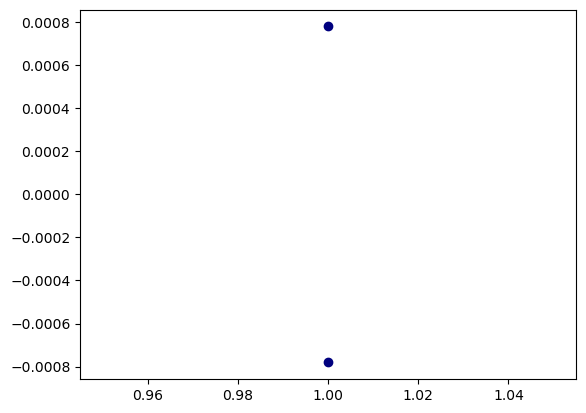

In [42]:
Mag = mean(Mag, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Mag[:,i], color=colors[i])
        plot(T, Magnetisation(T, 𝒽[i]), color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Mag[:,i], color=colors[i])
    end
end
savefig("figs/Magnetisation.png")

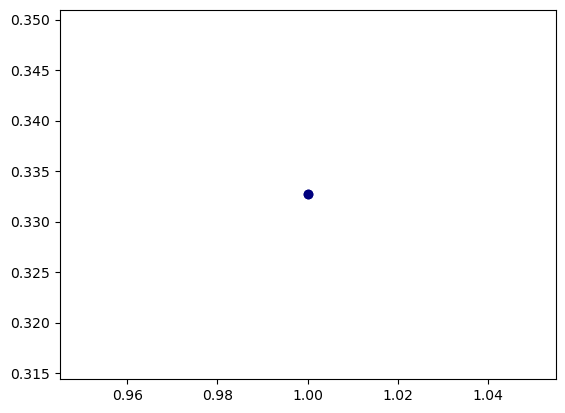

In [43]:
Perc = mean(Perc, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Perc[:,i], color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Perc[:,i], color=colors[i])
    end
end

savefig("figs/Percolation.png")

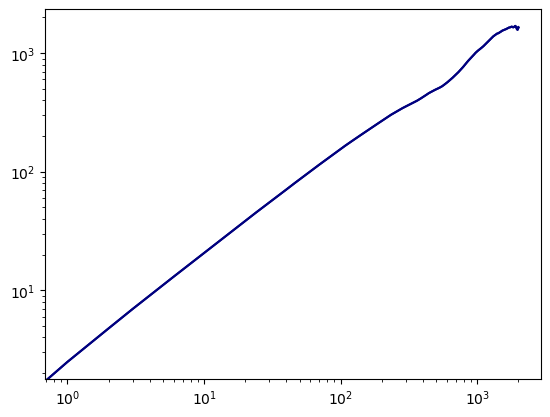

In [44]:
figure()
for t in size(MSD, 2)
    for i in size(MSD, 3)
        if MSD[:,t,i] != [NaN for _ in 1:size(MSD, 1)]
            loglog(MSD[:,t,i], color=colors[i])
            plot(MSD[:,t,i], color=colors[i])
        end
    end
end
#legend(loc = "upper right", bbox_to_anchor = (1.25, 1.0))
savefig("figs/MSD.png")

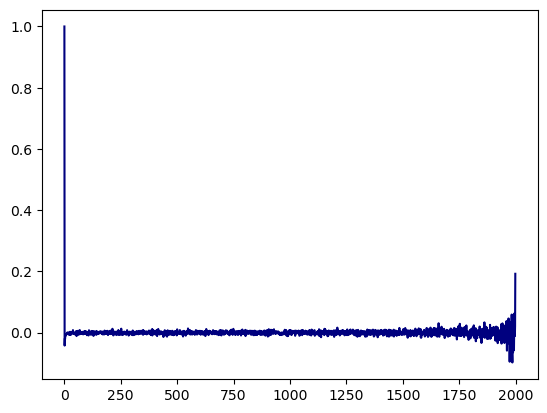

In [45]:
# step direction autocorrelation
figure()
for t in size(StepCorr, 2)
    for i in size(StepCorr, 3)
        if StepCorr[:,t,i] != [NaN for _ in 1:size(StepCorr, 1)]
            #loglog(abs.(StepCorr[:,t,i]), color=colors[i])
            plot(StepCorr[:,t,i], color=colors[i])
        end
    end
end
savefig("figs/StepCorr.png")

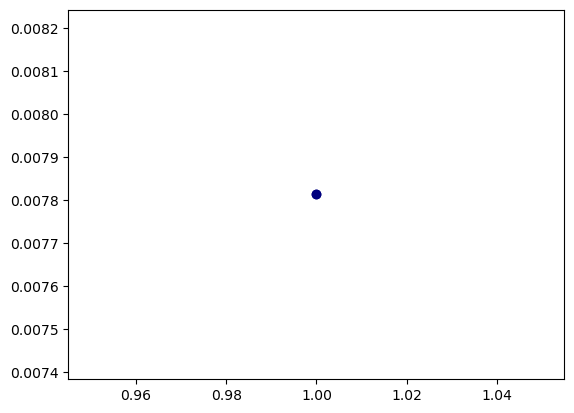

In [46]:
# estimate based on assuming the number of particles is <ϵ_i>/2λ/2 in single vertex approxn

figure() # density of quasiparticles
p = mean(p, dims=3) ./ Nv

if length(T) > 0
    nfun0 = (T) -> (1 .- tanh.(λ ./ T)) ./ 2
    Mfun0 = (T, h) -> tanh.(h ./ T)
    nfun = (T, h) -> nfun0(T .* (1 .- h .* Mfun0(T, h) ./ 2)) # 
    nfun2 = (T, h) -> nfun0(T ./ (1 .+ h .* Mfun0(T, h) ./ 2))
    
    for i in eachindex(𝒽)
        scatter(T, p[:,i], color=colors[i])
        plot(T, ExcitationDensity(T, 𝒽[i]), color=colors[i])
    end
elseif length(ℓ) > 0
    pExp = 2 .* ℓ ./ Nv
    
    for i in eachindex(𝒽)
        scatter(ℓ, p[:,i], color=colors[i])
    end
    plot(ℓ, pExp, color=:black, "--")
end
savefig("figs/Quasiparticle Number.png")

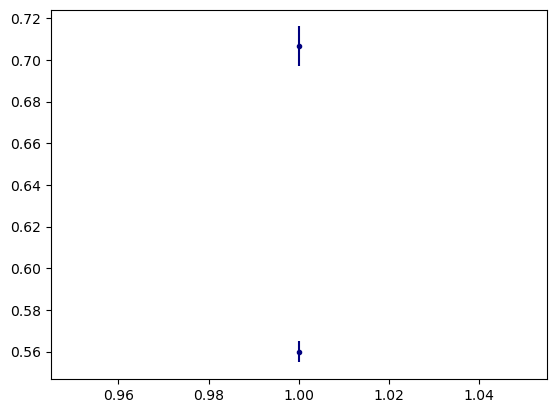

In [47]:
figure() # diffusion coefficient
nfun0 = (T) -> (1 .- tanh.(λ ./ T)) ./ 2
#nfun  = (T, h) -> 1 ./ (1 .+ exp.(2 .* λ ./ T) .* exp.(h ./ T ./ sqrt.(nfun0(T))))
#Dfun  = (T, h) -> (1 .- nfun(T, h)) .* (1 .- Mfun(T, h)) ./ 2
DfunPlus = (T, h) -> (1 .- nfun0(T)) .* (1 .+ Mfun(T, h)) ./ 2
DfunMinus = (T, h) -> (1 .- nfun0(T)) .* (1 .- Mfun(T, h)) ./ 2

#nfun = (T) -> λ == 0 ? 4 .* (exp.(-4 ./ T) .+ exp.(-16 ./ T)) ./ (3 .+ 4 .* exp.(-4 ./ T) .+ exp.(-16 ./ T)) : 0.5 .* (1 .- tanh.(λ ./ T))
#Dfun = (n) -> λ == 0 ? 7/12 .* (1 .- n) : 1 .* (1 .- n)

if length(T) > 0
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], T, colors[i], ".", D[2,:,i])
        #plot(T, DfunPlus(T, 𝒽[i]), color=colors[i])
        #plot(T, DfunMinus(T, 𝒽[i]), color=colors[i], "--")
    end
elseif length(ℓ) > 0
    #plot(ℓ, Dfun(2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], ℓ, colors[i], ".", D[2,:,i])
    end
end
savefig("figs/Diffusion Coefficient.png")

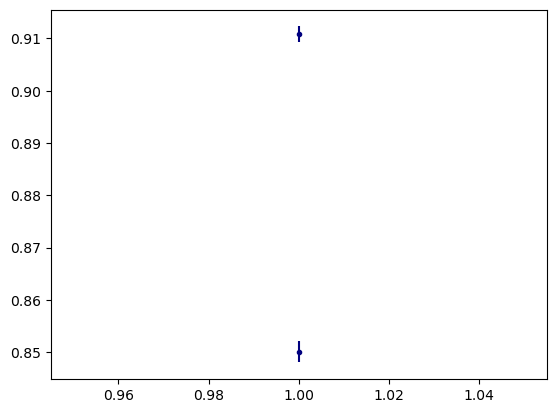

In [48]:
figure() # diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], T, colors[i], ".", α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], ℓ, colors[i], ".", α[2,:,i])
    end
end
savefig("figs/Diffusion Exponent.png")

In [49]:
t4 = now()
print("\n", canonicalize(t4 - t3))


20 seconds, 786 milliseconds

In [50]:
print("\nTOTAL RUNTIME = ", canonicalize(t4 - t0))


TOTAL RUNTIME = 3 minutes, 40 seconds, 789 milliseconds